Saving road.jpg to road (3).jpg


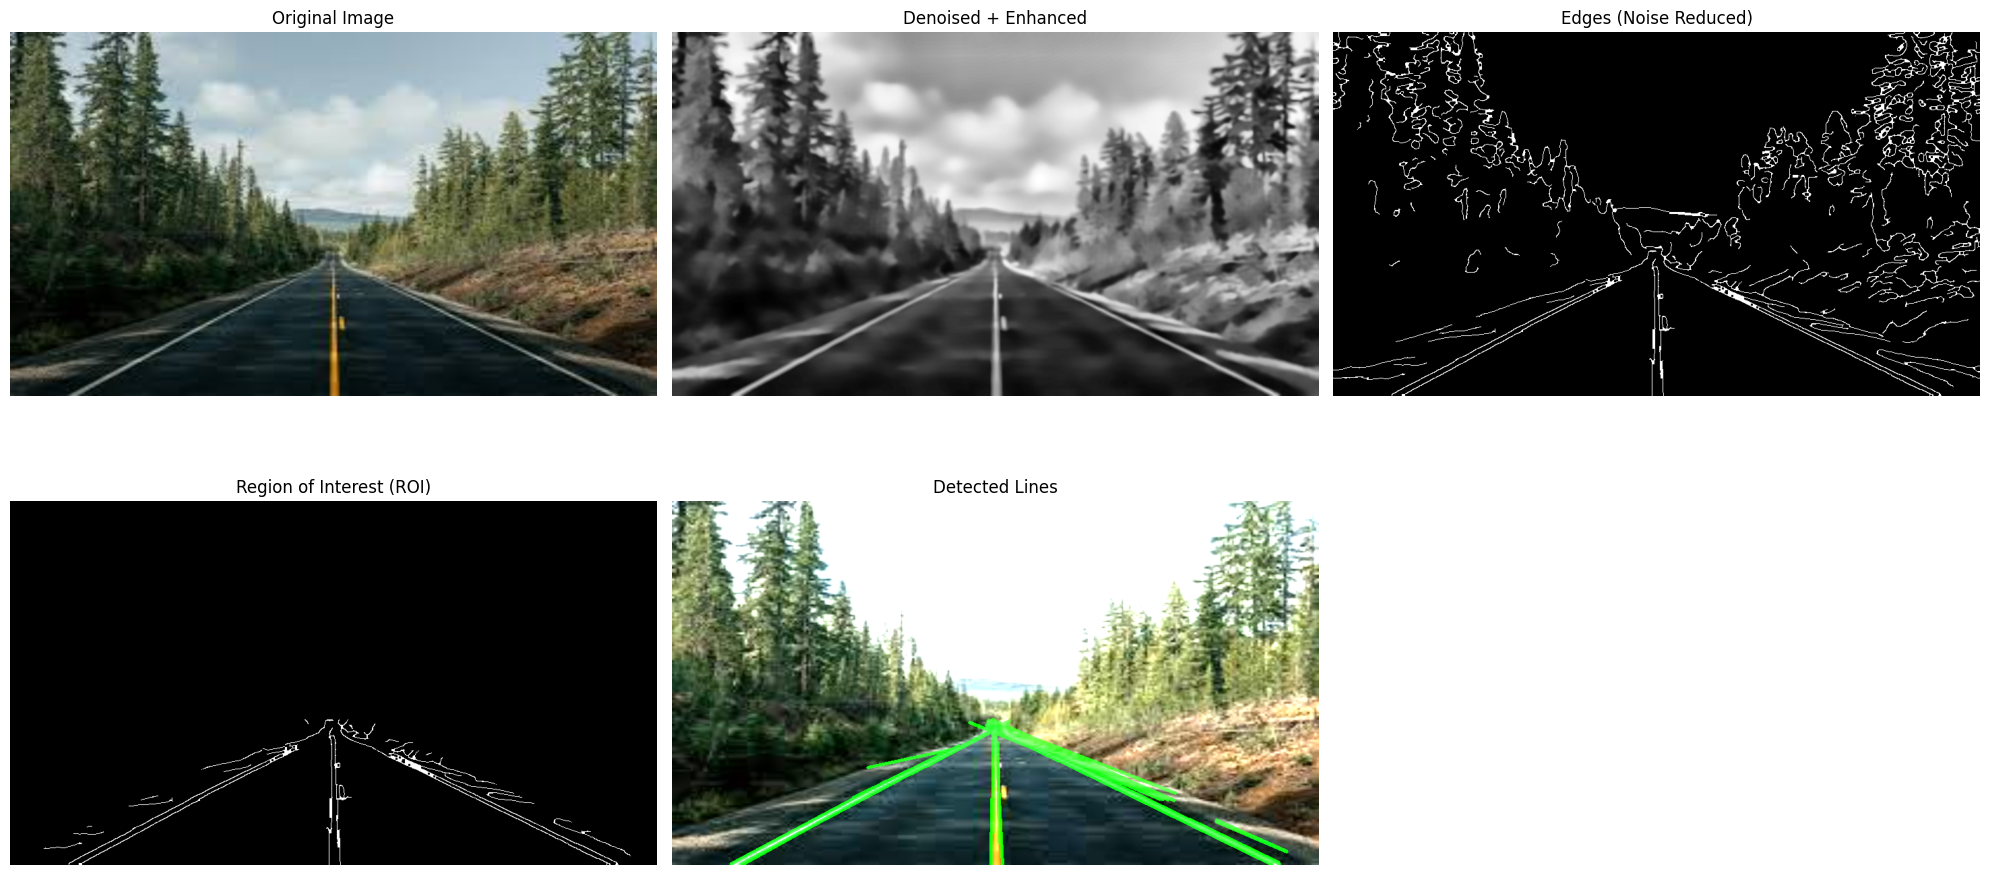

In [12]:
# =====================================================
# Robust Line Detection using Hough Transform (Noise-Resistant)
# =====================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files  # comment this line if running locally

# -------- Upload Image (Colab users) --------
try:
    uploaded = files.upload()  # comment if running locally
    img_path = list(uploaded.keys())[0]
except:
    img_path = input("Enter path to image: ")

# -------- Load Image --------
img = cv2.imread(img_path)
if img is None:
    raise ValueError("❌ Error: Could not read image. Please check the file path.")

# Resize for consistent processing
img = cv2.resize(img, (960, 540))

# -------- Step 1: Preprocessing (Noise Removal + Enhancement) --------
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Reduce noise (fastNlMeansDenoising is better for random noise)
denoised = cv2.fastNlMeansDenoising(gray, None, h=20)

# Slight Gaussian Blur for smoothing
blur = cv2.GaussianBlur(denoised, (5, 5), 0)

# Enhance contrast using CLAHE (good for dark or uneven lighting)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced = clahe.apply(blur)

# -------- Step 2: Edge Detection (Adaptive) --------
# Compute median for auto Canny thresholding
median_val = np.median(enhanced)
lower = int(max(0, 0.66 * median_val))
upper = int(min(255, 1.33 * median_val))
edges = cv2.Canny(enhanced, lower, upper)

# Optional: Morphological closing to fill gaps in edges
kernel = np.ones((3, 3), np.uint8)
edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

# -------- Step 3: ROI Mask (Focus on region of interest) --------
height, width = edges_closed.shape
mask = np.zeros_like(edges_closed)

polygon = np.array([[
    (0, height),
    (width, height),
    (int(0.55 * width), int(0.6 * height)),
    (int(0.45 * width), int(0.6 * height))
]], dtype=np.int32)

cv2.fillPoly(mask, polygon, 255)
roi = cv2.bitwise_and(edges_closed, mask)

# -------- Step 4: Hough Transform Line Detection --------
lines = cv2.HoughLinesP(
    roi,
    rho=1,
    theta=np.pi / 180,
    threshold=50,
    minLineLength=60,
    maxLineGap=50
)

# -------- Step 5: Draw Lines --------
line_img = np.copy(img)
if lines is None:
    print("❌ No lines detected. Try adjusting parameters or using a clearer image.")
else:
    for x1, y1, x2, y2 in lines[:, 0]:
        cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 4)

final = cv2.addWeighted(img, 0.8, line_img, 1, 0)

# -------- Step 6: Display Results --------
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(2, 3, 2)
plt.title("Denoised + Enhanced")
plt.imshow(enhanced, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 3)
plt.title("Edges (Noise Reduced)")
plt.imshow(edges_closed, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 4)
plt.title("Region of Interest (ROI)")
plt.imshow(roi, cmap="gray")
plt.axis("off")

plt.subplot(2, 3, 5)
plt.title("Detected Lines")
plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()
